# Graph-to-Simplicial Directed Clique Lifting Tutorial

***
This notebook shows how to import a dataset, with the desired lifting, and how to run a neural network using the loaded data.

The notebook is divided into sections:

- [Loading the dataset](#loading-the-dataset) loads the config files for the data and the desired tranformation, creates a dataset object and visualizes it.
- [Loading and applying the lifting](#loading-and-applying-the-lifting) defines a simple neural network to test that the lifting creates the expected incidence matrices.
- [Create and run a simplicial nn model](#create-and-run-a-simplicial-nn-model) simply runs a forward pass of the model to check that everything is working as expected.

***
***

Note that for simplicity the notebook is setup to use a simple graph. However, there is a set of available datasets that you can play with.

To switch to one of the available datasets, simply change the *dataset_name* variable in [Dataset config](#dataset-config) to one of the following names:

* cocitation_cora
* cocitation_citeseer
* cocitation_pubmed
* MUTAG
* NCI1
* NCI109
* PROTEINS_TU
* AQSOL
* ZINC
***

### Imports and utilities

In [1]:
# With this cell any imported module is reloaded before each cell execution
%load_ext autoreload
%autoreload 2
from modules.data.load.loaders import GraphLoader
from modules.data.preprocess.preprocessor import PreProcessor
from modules.transforms.liftings.graph2simplicial.directed_clique_lifting import (
    DirectedSimplicialCliqueLifting,
)
from modules.utils.utils import (
    describe_data,
    load_dataset_config,
    load_model_config,
    load_transform_config,
)
import networkx as nx
import torch
import torch_geometric

## Loading the Dataset

Here we just need to spicify the name of the available dataset that we want to load. First, the dataset config is read from the corresponding yaml file (located at `/configs/datasets/` directory), and then the data is loaded via the implemented `Loaders`.


In [2]:
dataset_name = "manual_dataset"
dataset_config = load_dataset_config(dataset_name)
loader = GraphLoader(dataset_config)


Dataset configuration for manual_dataset:

{'data_domain': 'graph',
 'data_type': 'toy_dataset',
 'data_name': 'manual',
 'data_dir': 'datasets/graph/toy_dataset',
 'num_features': 1,
 'num_classes': 2,
 'task': 'classification',
 'loss_type': 'cross_entropy',
 'monitor_metric': 'accuracy',
 'task_level': 'node'}


We can then access to the data through the `load()`method:


Dataset only contains 1 sample:


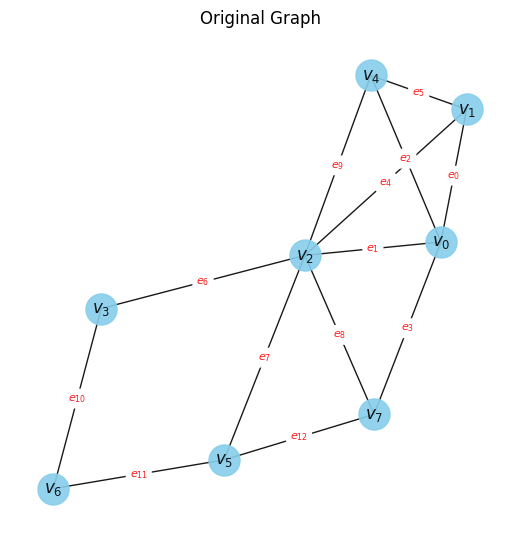

 - Graph with 8 vertices and 13 edges.
 - Features dimensions: [1, 0]
 - There are 0 isolated nodes.



In [3]:
dataset = loader.load()
describe_data(dataset)

## Loading and Applying the Lifting

To get a sense for how the directed clique/flag complex differs from the more common undirected version, we will generate a clique complex for a toy graph then augment its connectivity to be directed and observe the differences in their resulting simplicial structure.

For more information on the directed clique complex, see references [1,2].


***
[[1]](https://www.frontiersin.org/journals/computational-neuroscience/articles/10.3389/fncom.2017.00048/full) Reimann, Michael W., et al. "Cliques of neurons bound into cavities provide a missing link between structure and function." Frontiers in computational neuroscience 11 (2017): 266051.
[[2]](https://arxiv.org/abs/1906.10458) Lütgehetmann, Daniel, et al. "Computing persistent homology of directed flag complexes." Algorithms 13.1 (2020): 19.
***

For simplicial complexes creating a lifting involves creating a `SimplicialComplex` object from topomodelx and adding simplices to it using the method `add_simplices_from`. The `SimplicialComplex` class then takes care of creating all the needed matrices.

Similarly to before, we can specify the transformation we want to apply through its type and id --the correxponding config files located at `/configs/transforms`. 

Note that the *tranform_config* dictionary generated below can contain a sequence of tranforms if it is needed.

This can also be used to explore liftings from one topological domain to another, for example using two liftings it is possible to achieve a sequence such as: graph -> simplicial complex -> hypergraph. 

In [4]:
# Define transformation type and id
transform_type = "liftings"
# If the transform is a topological lifting, it should include both the type of the lifting and the identifier
transform_id_clique = "graph2simplicial/clique_lifting"

# Read yaml file
transform_config_clique = {
    "lifting": load_transform_config(transform_type, transform_id_clique)
    # other transforms (e.g. data manipulations, feature liftings) can be added here
}


Transform configuration for graph2simplicial/clique_lifting:

{'transform_type': 'lifting',
 'transform_name': 'SimplicialCliqueLifting',
 'complex_dim': 3,
 'preserve_edge_attr': False,
 'signed': True,
 'feature_lifting': 'ProjectionSum'}


We than apply the transform via our `PreProcesor`:

Transform parameters are the same, using existing data_dir: /home/tgebhart/projects/challenge-icml-2024/datasets/graph/toy_dataset/manual/lifting/2744620725

Dataset only contains 1 sample:


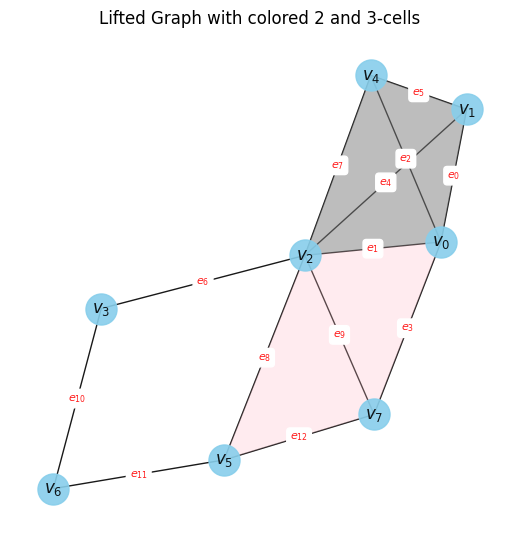

 - The complex has 8 0-cells.
 - The 0-cells have features dimension 1
 - The complex has 13 1-cells.
 - The 1-cells have features dimension 1
 - The complex has 6 2-cells.
 - The 2-cells have features dimension 1
 - The complex has 1 3-cells.
 - The 3-cells have features dimension 1



In [5]:
lifted_dataset = PreProcessor(dataset, transform_config_clique, loader.data_dir)
describe_data(lifted_dataset)

## Adding direction

Let's recreate this example graph to see how the directionality of the network affects the resulting simplicial complex structure.

To make our lives easier, we'll first create a plotting function which mimics the transformations that are going on behind the scenes within the data loader in the prior cells. Note that this helper function creates a `DirectedSimplicialCliqueLifting` function which we pass the underlying network data through.

In [6]:
def create_graph_and_plot(edges, node_data=dataset.data.x, complex_dim=3):
    """A helper function which creates a directed clique
    complex from a direct edgelist and plots its simplices.
    """
    G = nx.DiGraph(edges)
    edge_list = torch.Tensor(list(G.edges())).T.long()
    # Generate feature from 0 to 3
    directed_data = torch_geometric.data.Data(
        x=node_data, edge_index=edge_list, num_nodes=len(G.nodes)
    )

    # create lifting
    dcl = DirectedSimplicialCliqueLifting(complex_dim=complex_dim)
    directed_data = dcl.forward(directed_data.clone())
    describe_data({0: directed_data})

/home/tgebhart/anaconda3/envs/topox/lib/python3.11/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Let's start our investigation by re-creating the simplicial structure of the clique complex. Note that the edgelist below always treats vertex 2 as a source. Note also that vertex 1 is a sink to 2, 0, and 4.


Dataset only contains 1 sample:


/home/tgebhart/anaconda3/envs/topox/lib/python3.11/site-packages/scipy/sparse/_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


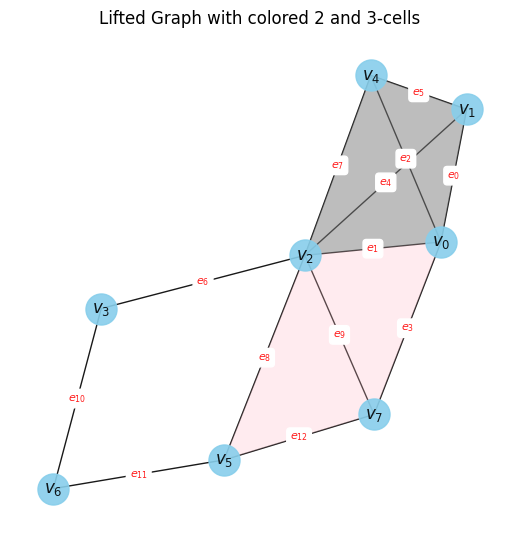

 - The complex has 8 0-cells.
 - The 0-cells have features dimension 1
 - The complex has 13 1-cells.
 - The 1-cells have features dimension 1
 - The complex has 6 2-cells.
 - The 2-cells have features dimension 1
 - The complex has 1 3-cells.
 - The 3-cells have features dimension 1



In [7]:
edges = [
    (2, 1),
    (2, 4),
    (2, 0),
    (4, 1),
    (0, 1),
    (0, 4),
    (7, 0),
    (2, 7),
    (2, 5),
    (5, 7),
    (6, 5),
    (6, 3),
    (2, 3),
]
create_graph_and_plot(edges)

As expected, we get back the exact same simplicial complex as when we used the undirected clique complex. Now what happens if we swap the direction of the edge connecting nodes 1 and 2? 


Dataset only contains 1 sample:


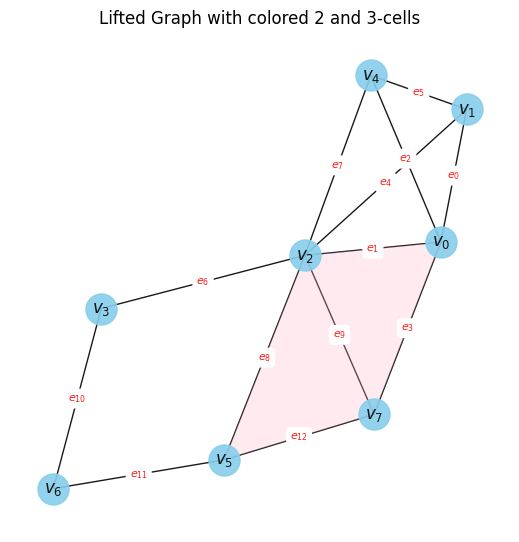

 - The complex has 8 0-cells.
 - The 0-cells have features dimension 1
 - The complex has 13 1-cells.
 - The 1-cells have features dimension 1
 - The complex has 2 2-cells.
 - The 2-cells have features dimension 1



In [8]:
edges = [
    (1, 2),  # reverse only this edge
    (2, 4),
    (2, 0),
    (4, 1),
    (0, 1),
    (0, 4),
    (7, 0),
    (2, 7),
    (2, 5),
    (5, 7),
    (6, 5),
    (6, 3),
    (2, 3),
]
create_graph_and_plot(edges)

By introducing a directed cycle into the clique (0,1,2,4), we've completely destroyed the 3-simplex. This behavior distinguishes the `DirectedSimplicialCliqueLifting` from the `SimplicialCliqueLifting`: cliques in the directed case must have a single source and sink node. This requirement is satisfied vacuously by graph vertices and edges. 

What about the 2-cells? Let's see if we can "unfill" one of the triangles (2-cells) in the figure above and "fill in" the triangles in the 4-clique:


Dataset only contains 1 sample:


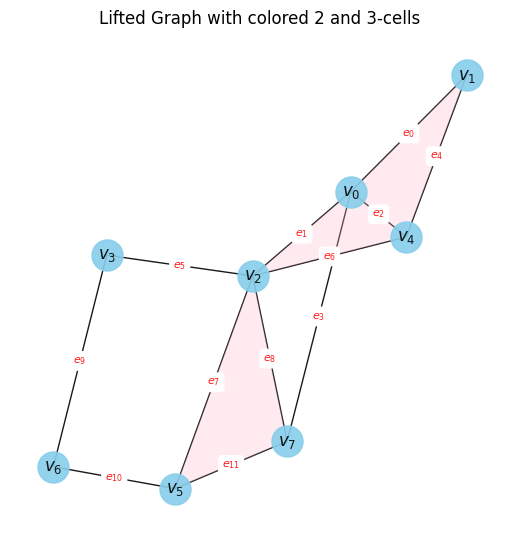

 - The complex has 8 0-cells.
 - The 0-cells have features dimension 1
 - The complex has 12 1-cells.
 - The 1-cells have features dimension 1
 - The complex has 3 2-cells.
 - The 2-cells have features dimension 1



In [9]:
edges = [
    # (2,1), # remove this edge to break the 4-clique
    (2, 4),
    (0, 2),  # change direction to unfill the triangle (0,2,7)
    (4, 1),
    (0, 1),
    (0, 4),
    (7, 0),
    (2, 7),
    (2, 5),
    (5, 7),
    (6, 5),
    (6, 3),
    (2, 3),
]
create_graph_and_plot(edges)

## Create and Run a Simplicial NN Model

In this section a simple model is created to test that the used lifting works as intended. In this case the model uses the `up_laplacian_1` and the `down_laplacian_1` so the lifting should make sure to add them to the data.

In [10]:
transform_id_directed_clique = "graph2simplicial/directed_clique_lifting"

# Read yaml file
transform_config_directed_clique = {
    "lifting": load_transform_config(transform_type, transform_id_directed_clique)
    # other transforms (e.g. data manipulations, feature liftings) can be added here
}

lifted_dataset = PreProcessor(
    dataset, transform_config_directed_clique, loader.data_dir
)


Transform configuration for graph2simplicial/directed_clique_lifting:

{'transform_type': 'lifting',
 'transform_name': 'DirectedSimplicialCliqueLifting',
 'complex_dim': 3,
 'preserve_edge_attr': False,
 'signed': True,
 'feature_lifting': 'ProjectionSum'}
Transform parameters are the same, using existing data_dir: /home/tgebhart/projects/challenge-icml-2024/datasets/graph/toy_dataset/manual/lifting/22337573


In [11]:
from modules.models.simplicial.san import SANModel

model_type = "simplicial"
model_id = "san"
model_config = load_model_config(model_type, model_id)

model = SANModel(model_config, dataset_config)


Model configuration for simplicial SAN:

{'in_channels': None,
 'hidden_channels': 32,
 'out_channels': None,
 'n_layers': 2,
 'n_filters': 2,
 'order_harmonic': 5,
 'epsilon_harmonic': 0.1}


In [12]:
y_hat = model(lifted_dataset.get(0))

If everything is correct the cell above should execute without errors. 